### Goal

#### Predict if the customer will subscribe (yes/no) to a term deposit

### Exploratory Data Analysis

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from feature_engine.missing_data_imputers import CategoricalVariableImputer
from feature_engine.missing_data_imputers import RandomSampleImputer
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.variable_transformers import YeoJohnsonTransformer
from feature_engine.discretisers import EqualWidthDiscretiser
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import metrics

#### Exploring the data

In [82]:
data =  pd.read_csv("D:\Apziva\\term-deposit-marketing-2020.csv")

In [83]:
data.shape

(40000, 14)

In [84]:
data.describe()

,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


In [85]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


In [86]:
# The target variable seems to be imbalanced
data["y"].value_counts()

no     37104
yes     2896
Name: y, dtype: int64

In [87]:
# Examining the data
for var in data.columns:
    print(var, data[var].unique())

age [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81]
job ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']
marital ['married' 'single' 'divorced']
education ['tertiary' 'secondary' 'unknown' 'primary']
default ['no' 'yes']
balance [  2143     29      2 ...   7222   3402 102127]
housing ['yes' 'no']
loan ['no' 'yes']
contact ['unknown' 'cellular' 'telephone']
day [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]
month ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr']
duration [ 261  151   76 ... 1880 1460 2219]
campaign [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 15 17 25 21
 43 51 63 41 26 28 55 50 38 23 20 29 31 37 30 46 27 58 33 35 34 36 39 44]


In [88]:
# making lists of variable types for numerical and categorical data
categorical = [var for var in data.columns if data[var].dtype == 'O' and var != 'y']

discrete = [var for var in data.columns if data[var].dtype != 'O' and len(data[var].unique()) < 20 
            and var != 'y']

continuous = [var for var in data.columns if data[var].dtype != 'O'and var not in discrete and var != 'y']

print(f'There are {len(continuous)} continuous variables')
print(f'There are {len(discrete)} discrete variables')
print(f'There are {len(categorical)} categorical variables')

There are 5 continuous variables
There are 0 discrete variables
There are 8 categorical variables


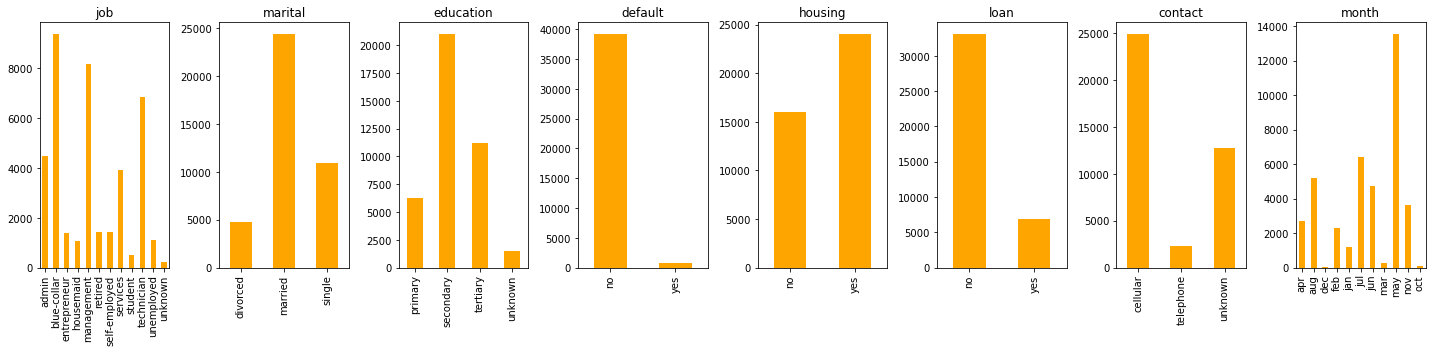

In [61]:
# Exploring the distribution of categorical data via histograms
fig, axes = plt.subplots(ncols = len(categorical), figsize=(20,5))
for col, ax in zip(categorical, axes):
    data[col].value_counts().sort_index().plot.bar(ax=ax, title=col, color=['orange'])

plt.tight_layout()    
plt.show()

In [41]:
# Checking for null data
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64

In [42]:
# the value 'unknown' in the attributes job, education and contact are essentially missing values 
# and can be replaced with NANs to future impute them

In [62]:
# we can impute unknown here with a random value given the relative small number of missing values
data["job"].value_counts()

blue-collar      9383
management       8166
technician       6852
admin            4483
services         3910
retired          1437
self-employed    1414
entrepreneur     1405
unemployed       1104
housemaid        1087
student           524
unknown           235
Name: job, dtype: int64

In [89]:
data["job"].replace({"unknown": np.nan}, inplace=True)

In [90]:
# we can impute unknown here with with the mode
data["education"].value_counts()

secondary    20993
tertiary     11206
primary       6270
unknown       1531
Name: education, dtype: int64

In [91]:
data["education"].replace({"unknown": np.nan}, inplace=True)

In [92]:
# leaving the unkown value as is since it is high in number
data["contact"].value_counts()

cellular     24914
unknown      12765
telephone     2321
Name: contact, dtype: int64

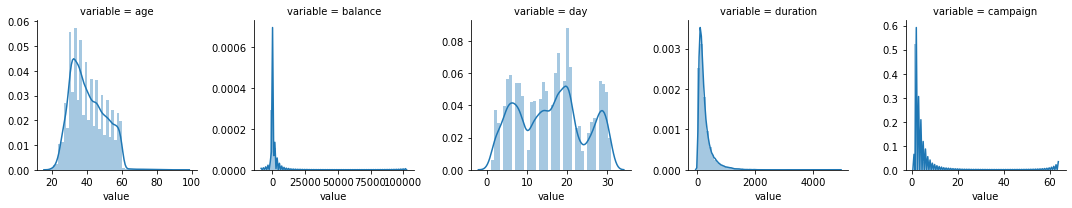

In [93]:
# Checking the distribution of the continuous variables via distplots
nd = pd.melt(data, value_vars = continuous)
n1 = sns.FacetGrid (nd, col = 'variable', col_wrap = 5, sharex = False, sharey = False)
n1 = n1.map(sns.distplot, 'value')
n1

In [94]:
data.skew(axis = 0, skipna = True).sort_values(ascending=False)

balance     8.259236
campaign    4.730901
duration    3.165307
age         0.436080
day         0.067930
dtype: float64

#### Correlation Matrix

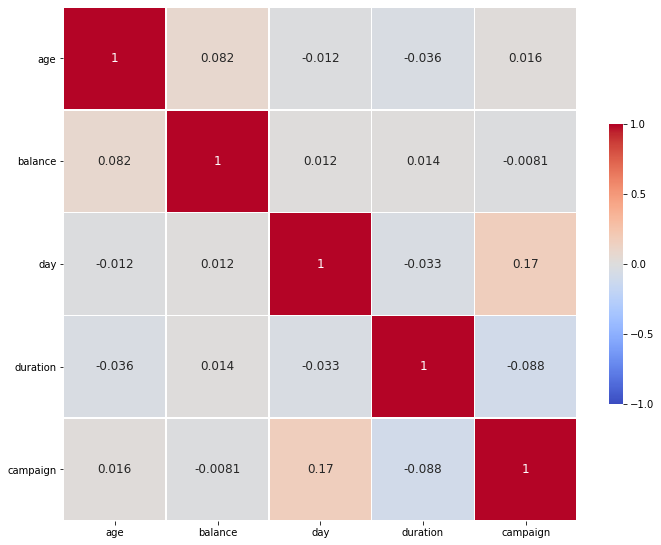

In [50]:
mask = np.zeros_like(data.corr(), dtype=np.bool)
f, ax = plt.subplots(figsize = (10,10)) 
heatmap = sns.heatmap(data.corr(), 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 12})

ax.set_yticklabels(data.corr().columns, rotation = 0)
ax.set_xticklabels(data.corr().columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
plt.tight_layout()

In [51]:
# We don't really see much of a linear relation between the numerical columns in the data

In [95]:
data["y"].value_counts()

no     37104
yes     2896
Name: y, dtype: int64

In [96]:
data["y"].replace({"yes": 1 , "no": 0}, inplace=True)

#### Splitting the Data

In [7]:
data.shape

(40000, 14)

In [99]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(data.drop('y',axis=1), data.y , test_size=0.2, stratify=data['y'], random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=0)

#### Preprocessing Pipeline

In [100]:
prep_pipe = Pipeline([
    # Imputers
    ('rand_imputer', RandomSampleImputer(random_state = 40,
                                         seed = 'general',
                                         variables = ['job'])),
    
    ('mode_imputer', CategoricalVariableImputer(imputation_method='frequent',
                                                variables = ['education'])),
    # Encoder
    ('onehot_encoder', OneHotCategoricalEncoder(variables = categorical,
                                                top_categories = None,
                                                drop_last = True)),
    # Transformer
    ('yjt', YeoJohnsonTransformer(variables = continuous)),
    
    # Discretiser
    ('ew_disc', EqualWidthDiscretiser(bins=10, variables = continuous)),
    
    # Scaling
    ("standardscaler" , StandardScaler(with_mean=True, with_std=False)),
    ("robustscaler" , RobustScaler(with_centering=False, with_scaling=True, quantile_range=(0, 100))) 
    ])

In [101]:
prep_pipe.fit(X_train, y_train)
X_train = prep_pipe.transform(X_train)
X_val = prep_pipe.transform(X_val)
X_test = prep_pipe.transform(X_test)

### Selecting an optimal metric

- The specified goal requires us to choose the model based on the metric accuracy.
- Using accuracy as the metric is not optimal to making the best prediction especially due to the fact that our data set is imbalanced
- For Ex: Suppose we have 80% of the data points of just class A ; we can achieve 80% accuracy by just making every prediction A

In [31]:
data['y'].value_counts()

0    11150
1      850
Name: y, dtype: int64

- To achieve an optimal result we would like to maximize two components:

(1) The "True Positive Rate" aka Sensitivity aka Recall. Given by: TP/(TP+FN)


(2) The Precision - How many of the positive predictions, are in fact correct. Given by: TP/(TP+FP)

- To obtain a balance between both we use F Measure which is given by: (2 x Precision x Recall)/(Precision+Recall)

In [23]:
#creating a scorer for F2 score so that we can given an emphases on the minority class predictions
from sklearn.metrics import fbeta_score, make_scorer
f2score = make_scorer(fbeta_score, beta=2)
f2score

make_scorer(fbeta_score, beta=2)

### Model Training

#### Basic Models

##### Logistic Regression (L2 Penalty)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
logreg_l2 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l2'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['sag'],
                'warm_start':[True,False]}

logreg_l2_grid = GridSearchCV(logreg_l2, logreg_param, cv = 5, return_train_score=True, scoring = f2score)
logreg_l2_grid.fit(X_train,y_train)

print("Best Parameters for Logistic Regression: ",logreg_l2_grid.best_params_)

print("Best Mean Cross-validation score: {:.2f}".format(logreg_l2_grid.best_score_))

print("Test Performance: {:.2f} ".format(logreg_l2_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(logreg_l2_grid.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'C': 0.5, 'dual': False, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'sag', 'warm_start': True}
Best Mean Cross-validation score: 0.47
Test Performance: 0.47 
Validation Performance: 0.47 


##### Logistic Regression (L1 Penalty)

In [48]:
logreg_l1 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['l1'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['liblinear'],
                'warm_start':[True]}

logreg_l1_grid = GridSearchCV(logreg_l1, logreg_param, cv = 5, return_train_score=True, scoring = f2score)
logreg_l1_grid.fit(X_train,y_train)

print("Best Parameters for Logistic Regression: ",logreg_l1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(logreg_l1_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(logreg_l1_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(logreg_l1_grid.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'C': 0.5, 'dual': False, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': True} 

Best Mean Cross-validation score: 0.50 

Test Performance: 0.48 
Validation Performance: 0.48 


##### Logistic Regression (Elastic Penalty)

In [52]:
logreg_l1 = LogisticRegression(max_iter=10000, random_state=42)

logreg_param = {'penalty':['elasticnet'],
                'dual':[False],
                'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['saga'],
                'warm_start':[True],
                'l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
                'class_weight':[None,'balanced'],}

logreg_l1_grid = GridSearchCV(logreg_l1, logreg_param, cv = 5, return_train_score=True, scoring= f2score)
logreg_l1_grid.fit(X_train,y_train)

print("Best Parameters: ",logreg_l1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(logreg_l1_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(logreg_l1_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(logreg_l1_grid.score(X_val,y_val)))

Best Parameters:  {'C': 0.1, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'l1_ratio': 0.8, 'penalty': 'elasticnet', 'solver': 'saga', 'warm_start': True} 

Best Mean Cross-validation score: 0.63 

Test Performance: 0.61 
Validation Performance: 0.62 


##### KNN 

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

param_knn = {'n_neighbors': range(5,25), 
             'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
             'weights':['uniform','distance']}

grid_knn = GridSearchCV(knn, param_knn, cv = 5, return_train_score = True, scoring = f2score)
grid_knn.fit(X_train, y_train)

print("Best Parameters: ",grid_knn.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(grid_knn.best_score_), '\n')

print("Test Performance: {:.2f} ".format(grid_knn.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(grid_knn.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'distance'}
Best Mean Cross-validation score: 0.14 

Test Performance: 0.17 
Validation Performance: 0.15 


##### Decision Tree

In [49]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)

param_dtree = {"max_depth": [1,2,3,4,5,7,9],
           "min_samples_split": [2,3,4],
           "max_leaf_nodes": [3,4,5],
           "criterion":['gini'],
           "splitter":['best','random']}

grid_dtree = GridSearchCV(dtree, param_dtree, cv = 5, return_train_score = True, scoring = f2score)
grid_dtree.fit(X_train, y_train)

print("Best Parameters: ",grid_dtree.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(grid_dtree.best_score_), '\n')

print("Test Performance: {:.2f} ".format(grid_dtree.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(grid_dtree.score(X_val,y_val)))

Best Parameters for Logistic Regression:  {'criterion': 'gini', 'max_depth': 2, 'max_leaf_nodes': 4, 'min_samples_split': 2, 'splitter': 'random'} 

Best Mean Cross-validation score: 0.37 

Test Performance: 0.37 
Validation Performance: 0.34 


##### Linear SVC

In [53]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(random_state=42)

param = [{'penalty':['l2'],
          'C': [0.001, 0.002, 0.0001, 0.008, 0.01, 0.1], 
          'loss':['hinge','squared_hinge']}]

svc_grid = GridSearchCV(lsvc, param, cv = 5 ,return_train_score = True ,scoring = f2score)
svc_grid.fit(X_train, y_train)

print("Best Parameters: ",svc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(svc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(svc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(svc_grid.score(X_val,y_val)))

Best Parameters:  {'C': 0.1, 'loss': 'squared_hinge', 'penalty': 'l2'} 

Best Mean Cross-validation score: 0.18 

Test Performance: 0.21 
Validation Performance: 0.17 


##### Kernel SVC

In [51]:
from sklearn.svm import SVC
svc = SVC()
param_grid = [{'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['poly'],
               'degree': [2, 3, 4, 5, 6]},
              {'kernel': ['sigmoid'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}]

svm_grid = GridSearchCV(svc, param_grid, cv = 5 ,return_train_score = True ,scoring = f2score)
svm_grid.fit(X_train, y_train)

print("Best Parameters: ",svm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(svm_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(svm_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(svm_grid.score(X_val,y_val)))

Best Parameters:  {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'} 

Best Mean Cross-validation score: 0.36 

Test Performance: 0.37 
Validation Performance: 0.36 


##### SGD Classifier

In [54]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc_param = {'penalty': ['l2', 'l1','elasticnet'],
              'l1_ratio': [0.1,0.3,0.5,0.7,0.9],
              'alpha': [0.0001, 0.001, 0.01, 0.02, 0.05, 1, 10],
              'fit_intercept': [True, False],
              'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
              'eta0': [0.001, 0.01,0.05,0.1,0.2,0.3,0.4,0.5]
                     }    

sgdc_grid = GridSearchCV(sgdc, sgdc_param, cv = 5, return_train_score = True, scoring = f2score)
sgdc_grid.fit(X_train, y_train)

print("Best Parameters: ",sgdc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(sgdc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(sgdc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(sgdc_grid.score(X_val,y_val)))

Best Parameters:  {'alpha': 0.0001, 'eta0': 0.1, 'fit_intercept': False, 'l1_ratio': 0.7, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'} 

Best Mean Cross-validation score: 0.58 

Test Performance: 0.56 
Validation Performance: 0.58 


##### LDA

In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid = {'solver' : ['lsqr', 'eigen'],
              'shrinkage': [None, 0.0001, 0.001, 0.01, 0.0005, 0.005, 0.05, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}    

lda_grid = GridSearchCV(LinearDiscriminantAnalysis(), param_grid, cv = 5, scoring = f2score, return_train_score = True)

lda_grid.fit(X_train,y_train)

print("Best Parameters: ",lda_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(lda_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(lda_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(lda_grid.score(X_val,y_val)))

Best Parameters:  {'shrinkage': None, 'solver': 'lsqr'} 

Best Mean Cross-validation score: 0.27 

Test Performance: 0.31 
Validation Performance: 0.25 


##### MLP Classifier

In [59]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(hidden_layer_sizes=(12, 8, 4), max_iter = 500, random_state = 42)
param = {}

mlp_grid= GridSearchCV(mlpc, param, cv = 10, return_train_score = True, scoring = f2score)
mlp_clf = mlp_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {:.2f}".format(mlp_clf.best_score_), '\n')

print("Test Performance: {:.2f} ".format(mlp_clf.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(mlp_clf.score(X_val,y_val)))

Best Mean Cross-validation score: 0.44 

Test Performance: 0.43 
Validation Performance: 0.41 


#### Ensemble Models

##### Bagging with DTree

In [62]:
from sklearn.ensemble import BaggingClassifier
bag_dtree1 = BaggingClassifier(base_estimator=DecisionTreeClassifier(), bootstrap = True, 
                               random_state=0, oob_score = False)

bag_dtree1_param = {
                 'base_estimator__max_depth': [1,2,3,4,5,7,9],
                 'base_estimator__max_leaf_nodes': [2,3,4,5],
                 'base_estimator__min_samples_split':[2,3,4],
                 'base_estimator__criterion':['gini','entropy'],
                 'max_samples':  [0.8,1],
                 'n_estimators': [50,100,200]}

bag_dtree1_grid = GridSearchCV(bag_dtree1, bag_dtree1_param,cv = 5, return_train_score = True, scoring = f2score)
bag_dtree1_grid.fit(X_train,y_train)

print("Best Parameters: ",bag_dtree1_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(bag_dtree1_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(bag_dtree1_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(bag_dtree1_grid.score(X_val,y_val)))

Best Parameters:  {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 2, 'base_estimator__max_leaf_nodes': 4, 'base_estimator__min_samples_split': 2, 'max_samples': 0.8, 'n_estimators': 50} 

Best Mean Cross-validation score: 0.35 

Test Performance: 0.34 
Validation Performance: 0.32 


##### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
rfc_param = {'n_estimators': [200, 500],
            'max_features': ['auto'],
            'max_depth' : [2,4,6,8,9],
            'criterion' :['gini', 'entropy'],
            'min_samples_split':[2,3,4,6,8],
            'min_samples_leaf': [1,2,3,4]}

rfc_grid = GridSearchCV(rfc, rfc_param,cv = 5, return_train_score = True, scoring = f2score)
rfc_grid.fit(X_train,y_train)

print("Best Parameters: ",rfc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(rfc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(rfc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(rfc_grid.score(X_val,y_val)))

Best Parameters:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200} 

Best Mean Cross-validation score: 0.02 

Test Performance: 0.03 
Validation Performance: 0.02 


##### Gradient Boosting Classifier

In [30]:
from  sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
gbc= GradientBoostingClassifier(random_state = 42)
gbc_param = {
              'min_samples_split':[2,3],
              'subsample':[0.6,0.8,1],
              'min_samples_leaf':[1,2],
              'max_depth' : [2,3,4,7],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2]
             }

gbc_grid = RandomizedSearchCV(gbc, gbc_param,cv = 5, return_train_score = True, scoring = f2score)
gbc_grid.fit(X_train,y_train)
print("Best Parameters: ",gbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(gbc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(gbc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(gbc_grid.score(X_val,y_val)))

Best Parameters:  {'subsample': 0.6, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.5} 

Best Mean Cross-validation score: 0.40 

Test Performance: 0.42 
Validation Performance: 0.40 


##### XGBoost Classifier

In [31]:
from xgboost import XGBClassifier
xgbc= XGBClassifier(random_state = 42,early_stopping_rounds=2,objective= 'binary:logistic')

xgbc_param = {
              'max_depth' : [2,5,7],
              'n_estimators' : [100,150,300],
              'learning_rate' : [0.5,1,2],
              'gamma' : [0.5,1.0,2],
              'min_child_weight' : [1,2],
              'subsample':[0.8,1],
              'colsample_bytree':[0.6,0.8],
              'lambda':[0.1,0.5,1],
              'alpha':[0.1,0.5,1]
             }

xgbc_grid = RandomizedSearchCV(xgbc, xgbc_param,cv = 5, return_train_score = True, scoring = f2score)
xgbc_grid.fit(X_train,y_train)
print("Best Parameters: ",xgbc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(xgbc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(xgbc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(xgbc_grid.score(X_val,y_val)))

Best Parameters:  {'subsample': 1, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 1, 'lambda': 1, 'gamma': 2, 'colsample_bytree': 0.8, 'alpha': 1} 

Best Mean Cross-validation score: 0.41 

Test Performance: 0.43 
Validation Performance: 0.40 


##### CATBoost Classsifier

In [111]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier()

param_grid = {
            'depth':[7,9,10,11,12],
            'iterations':[500,750,1000], 
            'learning_rate':[0.2,0.25,0.3,0.4], 
            'l2_leaf_reg':[7,8,9,10,15], 
            'border_count':[4,5,6,7,8]
                      }

cat_grid = RandomizedSearchCV(cat, param_grid, cv = 10, return_train_score = True, scoring = f2score)
cat_grid.fit(X_train,y_train)

print("Best Parameters: ",cat_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(cat_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cat_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cat_grid.score(X_val,y_val)))

Best Parameters:  {'learning_rate': 0.25, 'l2_leaf_reg': 9, 'iterations': 750, 'depth': 9, 'border_count': 5} 
{'learning_rate': 0.3, 'l2_leaf_reg': 10, 'iterations': 1000, 'depth': 7, 'border_count': 5}

Best Mean Cross-validation score: 0.42 

Test Performance: 0.42 
Validation Performance: 0.40 

##### LightGBM Classifier

In [43]:
import lightgbm as lgb
param_grid = {'num_leaves': [10,20,30,40,50,60,70,80,90,100,150,200],
              'max_depth': [4,5,6,7,8,9,10,11,12,13,14,15],
              'learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'n_estimators': [10, 30, 50, 70, 90, 100, 120, 150, 170, 200], 
              'min_split_gain' : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
              'reg_alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
              'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

mdl = lgb.LGBMClassifier(random_state = 42,
                         objective = 'binary')

lgbm_grid = RandomizedSearchCV(mdl, param_grid, cv = 5, return_train_score = True, scoring = f2score)
lgbm_grid.fit(X_train,y_train)

print("Best Parameters: ",lgbm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(lgbm_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(lgbm_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(lgbm_grid.score(X_val,y_val)))

Best Parameters:  {'reg_lambda': 0.3, 'reg_alpha': 0.5, 'num_leaves': 200, 'n_estimators': 100, 'min_split_gain': 0.7, 'max_depth': 7, 'learning_rate': 0.9} 

Best Mean Cross-validation score: 0.41 

Test Performance: 0.43 
Validation Performance: 0.46 


#### Cost Sensitive Algorithms

The idea behind using Cost Sensitive Algorithms is to given varying weights to each of the classes while building the model in an effort to built better predictors

##### Logistic Regression

In [46]:
#cost sensitive logistic regession L2 regularization
param_grid = {
    'penalty':['l2'],
    'dual':[False],
    'C':[0.001, 0.01, 0.1, 0.2, 0.5], 
    'fit_intercept':[True,False],
    'solver':['sag'],
    'warm_start':[True,False],
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}
#apply grid search
cgrid_logreg = GridSearchCV(LogisticRegression(random_state = 42, max_iter = 10000),
                           param_grid, cv = 5, n_jobs = -1, scoring = f2score)
cgrid_logreg.fit(X_train, y_train)

print("Best Parameters: ",cgrid_logreg.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cgrid_logreg.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cgrid_logreg.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cgrid_logreg.score(X_val,y_val)))

Best Parameters:  {'C': 0.2, 'class_weight': {0: 1, 1: 10}, 'dual': False, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'sag', 'warm_start': True} 

Best Mean Cross-validation score: 0.63 

Test Performance: 0.61 
Validation Performance: 0.62 


In [35]:
# cost sensitive logistic regession elasticnet
param_grid = {'penalty':['elasticnet'],
                'dual':[False],
                'C':[0.01, 0.1, 0.2, 0.5], 
                'fit_intercept':[True,False],
                'solver':['saga'],
                'warm_start':[True],
                'l1_ratio':[0.4,0.7,0.8,0.9],
                'class_weight': [{0:1,1:1}, {0:1,1:5}, {0:1,1:10}, {0:1,1:100}]}

cgrid_logreg = RandomizedSearchCV(LogisticRegression(random_state = 42, max_iter = 100000),
                            param_grid, cv = 5, n_jobs = -1, scoring = f2score)
cgrid_logreg.fit(X_train, y_train)

print("Best Parameters: ",cgrid_logreg.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cgrid_logreg.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cgrid_logreg.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cgrid_logreg.score(X_val,y_val)))

Best Parameters:  {'warm_start': True, 'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.8, 'fit_intercept': False, 'dual': False, 'class_weight': {0: 1, 1: 10}, 'C': 0.5} 

Best Mean Cross-validation score: 0.45 

Test Performance: 0.46 
Validation Performance: 0.45 


##### Kernel Support Vector Machine

In [32]:
from sklearn.svm import SVC
svc = SVC()
param_grid = {'kernel': ['rbf'],
               'C': [0.001, 0.01, 0.1, 1, 10, 100],
               'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
               'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
             }

cs_svm_grid = RandomizedSearchCV(svc, param_grid, cv = 5 ,return_train_score = True ,scoring = f2score)
cs_svm_grid.fit(X_train, y_train)

print("Best Parameters: ",cs_svm_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(cs_svm_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cs_svm_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cs_svm_grid.score(X_val,y_val)))

Best Parameters:  {'kernel': 'rbf', 'gamma': 0.01, 'class_weight': {0: 1, 1: 10}, 'C': 0.1} 

Best Mean Cross-validation score: 0.55 

Test Performance: 0.55 
Validation Performance: 0.55 


##### SGDClassifier

In [37]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(random_state=42)
sgdc_param = {
    'penalty': ['elasticnet'],
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}    

cs_sgdc_grid = GridSearchCV(sgdc, sgdc_param, cv = 5, return_train_score = True, scoring = f2score)
cs_sgdc_grid.fit(X_train, y_train)

print("Best Parameters: ",cs_sgdc_grid.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(cs_sgdc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cs_sgdc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cs_sgdc_grid.score(X_val,y_val)))

Best Parameters:  {'class_weight': {0: 1, 1: 10}, 'penalty': 'elasticnet'} 

Best Mean Cross-validation score: 0.62 

Test Performance: 0.59 
Validation Performance: 0.61 


##### LightGBM

In [68]:
import lightgbm as lgb
param_grid = { 
'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}

lgb_cs = GridSearchCV(lgb.LGBMClassifier(), 
                         param_grid, cv = 5, n_jobs = 2, scoring = f2score)


lgb_cs.fit(X_train, y_train)
print("Best Parameters: ",lgb_cs.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(lgb_cs.best_score_), '\n')

print("Test Performance: {:.2f} ".format(lgb_cs.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(lgb_cs.score(X_val,y_val)))

Best Parameters:  {'class_weight': {0: 1, 1: 100}} 

Best Mean Cross-validation score: 0.65 

Test Performance: 0.65 
Validation Performance: 0.66 


##### XGBoost

In [59]:
from xgboost import XGBClassifier
param_grid = { 
    'scale_pos_weight': [1, 2, 10, 25, 50, 75, 99, 100],
}
cgrid_xgboost= GridSearchCV(XGBClassifier(), param_grid, cv = 5, n_jobs = -1, scoring = f2score)
cgrid_xgboost.fit(X_train, y_train)

print("Best Parameters: ",cgrid_xgboost.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cgrid_xgboost.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cgrid_xgboost.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cgrid_xgboost.score(X_val,y_val)))

Best Parameters:  {'scale_pos_weight': 99} 

Best Mean Cross-validation score: 0.57 

Test Performance: 0.64 
Validation Performance: 0.60 


##### CatBoost

In [112]:
from catboost import CatBoostClassifier
param_grid = { 
'depth':[7,9],
'class_weights' : [[100,1], [10,80], [70,1], [1,1], [1,10], [1,100], [1,50]]
}
cat_grid_cs = GridSearchCV(CatBoostClassifier(border_count = 5, iterations = 750, l2_leaf_reg = 15, 
                                              learning_rate = 0.25), 
                           param_grid, cv=5, n_jobs = -1, scoring = f2score)

cat_grid_cs.fit(X_train, y_train)

print("Best Parameters: ",cat_grid_cs.best_params_, '\n')
print("Best Mean Cross-validation score: {:.2f}".format(cat_grid_cs.best_score_), '\n')

print("Test Performance: {:.2f} ".format(cat_grid_cs.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(cat_grid_cs.score(X_val,y_val)))

prediction_test = cat_grid_cs.predict(X_test)
prediction_val = cat_grid_cs.predict(X_val)

Best Parameters:  {'class_weights': [1, 100], 'depth': 7} 

Best Mean Cross-validation score: 0.65 

Test Performance: 0.65 

Validation Performance: 0.64 

#### Data Sampling

The idea is to change the dataset used to build the models by:

1) Adding copies of instances from the under-represented class called over-sampling (via various SMOTE methods)

2) Deleting instances from the over-represented class, called under-sampling

In [36]:
from imblearn.pipeline import Pipeline

In [37]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline
from numpy import mean
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN

##### SGD Classifier

In [42]:
# SMOTE and Undersampling
sgdc = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('sgdc', SGDClassifier(penalty = 'elasticnet', random_state = 42))])

param_sgdc = {'smote__k_neighbors': [1,2,3,4,5,7,10,12,15]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
sgdc_ds1 = GridSearchCV(sgdc,param_sgdc, cv = cv, n_jobs = -1, scoring=f2score)
sgdc_ds1.fit(X_train, y_train)

print("Best Parameters: ",sgdc_ds1.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(sgdc_ds1.best_score_), '\n')

print("Test Performance: {:.2f} ".format(sgdc_ds1.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(sgdc_ds1.score(X_val,y_val)))

Best Parameters:  {'smote__k_neighbors': 15} 

Best Mean Cross-validation score: 0.60 

Test Performance: 0.62 
Validation Performance: 0.63 


##### Logistic Regression

In [52]:
# SMOTE and Undersampling
logreg = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('logistic', LogisticRegression(max_iter = 20000, random_state = 42))])

logreg_param = {'logistic__penalty':['elasticnet'],
                'logistic__dual':[False],
                'logistic__C':[0.01, 0.1, 0.2], 
                'logistic__fit_intercept':[True,False],
                'logistic__solver':['saga'],
                'logistic__warm_start':[True],
                'logistic__l1_ratio':[0.2,0.5,0.7,0.8],
                'smote__k_neighbors': [3,5,7,10]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
log_ds1 = GridSearchCV(logreg, logreg_param, cv = cv, n_jobs = -1, scoring = f2score)
log_ds1.fit(X_train, y_train)

print("Best Parameters: ",log_ds1.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(log_ds1.best_score_), '\n')

print("Test Performance: {:.2f} ".format(log_ds1.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(log_ds1.score(X_val,y_val)))

Best Parameters:  {'logistic__C': 0.1, 'logistic__dual': False, 'logistic__fit_intercept': True, 'logistic__l1_ratio': 0.8, 'logistic__penalty': 'elasticnet', 'logistic__solver': 'saga', 'logistic__warm_start': True, 'smote__k_neighbors': 5} 

Best Mean Cross-validation score: 0.61 

Test Performance: 0.63 
Validation Performance: 0.62 


##### XGBoost

In [71]:
xgb_pipe = Pipeline([('smote', SMOTE()),
                 ('under', RandomUnderSampler()),
                 ('xgb', XGBClassifier(alpha = 1, colsample_bytree = 0.8, gamma = 2, 
                                       learning_rate = 1, max_depth = 7, min_child_weight = 1, 
                                       n_estimators = 150, subsample = 1, objective='binary:logistic',
                                       random_state=42))])

param_xgb = {'smote__k_neighbors': [1,2,3,4,5,7,10,12,15]}

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 42)
xgb_ds = GridSearchCV(xgb_pipe, param_xgb, cv = cv, n_jobs = -1, scoring = f2score)
xgb_ds.fit(X_train, y_train)

print("Best Parameters: ",xgb_ds.best_params_, '\n')

print("Best Mean Cross-validation score: {:.2f}".format(xgb_ds.best_score_), '\n')

print("Test Performance: {:.2f} ".format(xgb_ds.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(xgb_ds.score(X_val,y_val)))

Best Parameters:  {'smote__k_neighbors': 7} 

Best Mean Cross-validation score: 0.44 

Test Performance: 0.47 
Validation Performance: 0.43 


#### Probabilty Calibration

##### SGD Classifier

In [73]:
from sklearn.calibration import CalibratedClassifierCV
model = SGDClassifier()

calibrated = CalibratedClassifierCV(model, method='sigmoid', cv = 5)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state = 1)

param = {}
sgd_pc_grid = GridSearchCV(calibrated, param, cv = cv, n_jobs = -1, scoring = f2score)

sgd_pc_grid.fit(X_train,y_train)
print("Best Mean Cross-validation score: {:.2f}".format(sgd_pc_grid.best_score_), '\n')

print("Test Performance: {:.2f} ".format(sgd_pc_grid.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(sgd_pc_grid.score(X_val,y_val)))

Best Mean Cross-validation score: 0.21 

Test Performance: 0.24 
Validation Performance: 0.20 


##### XGBoost

In [105]:
from sklearn.calibration import CalibratedClassifierCV
model = XGBClassifier()
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
param = {}
# evaluate model
xgb_pc_grid= GridSearchCV(calibrated, param, cv=cv, n_jobs=-1, scoring=f2score)

xgb_pc = xgb_pc_grid.fit(X_train,y_train)

print("Best Mean Cross-validation score: {:.2f}".format(xgb_pc.best_score_), '\n')

print("Test Performance: {:.2f} ".format(xgb_pc.score(X_test,y_test)))
print("Validation Performance: {:.2f} ".format(xgb_pc.score(X_val,y_val)))

Best Mean Cross-validation score: 0.20 

Test Performance: 0.17 
Validation Performance: 0.16 


### Results

#### Best Performing Model - Cost Sensitive CatBoost Classifier

In [ ]:
## Assess Metrics
from catboost import CatBoostClassifier
model = CatBoostClassifier(border_count = 5, iterations = 1000, l2_leaf_reg = 10, 
                          depth = 7, learning_rate = 0.3, class_weights = [1, 100])
model.fit(X_train,y_train)
prediction_test = model.predict(X_test)
prediction_val = model.predict(X_val)

In [109]:
print("Test Set Performance (F2Score): {:.2f} ".format(cat_grid_cs.score(X_test,y_test)))
print("Validation Set Performance (F2Score): {:.2f} ".format(cat_grid_cs.score(X_val,y_val)), "\n")

from sklearn import metrics
print("Accuracy Test Set:",metrics.accuracy_score(prediction_test,y_test))
print("Accuracy Validation Set:",metrics.accuracy_score(prediction_val,y_val),"\n")

print("Recall Score Test Set:",metrics.recall_score(prediction_test,y_test))
print("Recall Score Validation Set:",metrics.recall_score(prediction_val,y_val),"\n")

print("Precision Score Test Set:",metrics.precision_score(prediction_test,y_test))
print("Precision Score Validation Set:",metrics.precision_score(prediction_val,y_val),"\n")

print("ROC_AUC curve Test Set:",metrics.roc_auc_score(prediction_test,y_test))
print("ROC_AUC curve Validation Set:",metrics.roc_auc_score(prediction_val,y_val),"\n")

print("Confusion Matrix Test Set:\n",metrics.confusion_matrix(prediction_test,y_test),"\n")
print("Confusion Matrix Validation Set:\n",metrics.confusion_matrix(prediction_val,y_val))

Test Set Performance (F2Score): 0.65 
Validation Set Performance (F2Score): 0.66  

Accuracy Test Set: 0.862875
Accuracy Validation Set: 0.868375 

Recall Score Test Set: 0.3282493368700265
Recall Score Validation Set: 0.32859078590785906 

Precision Score Test Set: 0.8549222797927462
Precision Score Validation Set: 0.886654478976234 

ROC_AUC curve Test Set: 0.6576551675107988
ROC_AUC curve Validation Set: 0.6595437068717712 

Confusion Matrix Test Set:
 [[6408   84]
 [1013  495]] 

Confusion Matrix Validation Set:
 [[6462   62]
 [ 991  485]]


Text(0.5, 1.0, 'Precision-Recall curve: ')

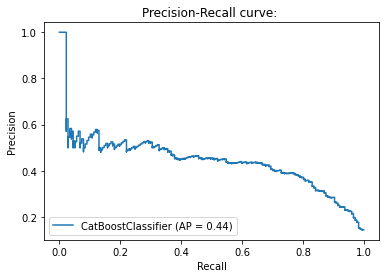

In [121]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve: ')

#### Understanding the importance of features

##### To find out how likely a customer is to subscribe to a term deposit below is a detailed assessment of the relative importance of the features in our dataset.

Using feature importances mechanisms we can guage how the features conribute to making optimal predictions via four procedures:

1) Prediction Value Changes

2) Loss Function Change

3) SHAP Values

4) Permutation Feature Importances

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(border_count = 5, iterations = 750, l2_leaf_reg = 15, 
                          depth = 7, learning_rate = 0.25, class_weights = [1, 50])
model.fit(X_train,y_train)
prediction_test = model.predict(X_test)
prediction_val = model.predict(X_val)

PredictionValuesChange shows how much on average the prediction changes if the feature value changes.

The bigger the value the bigger on average is the change to the prediction value if this feature is changed.

In [26]:
pvc = list(model.get_feature_importance(type= "PredictionValuesChange"))

In [28]:
data_vals = data.columns[0:44]
PredVals = pd.DataFrame()
PredVals["x"] = data_vals
PredVals["y"] = pvc
PredVals.sort_values("y", inplace = True, ascending = False)

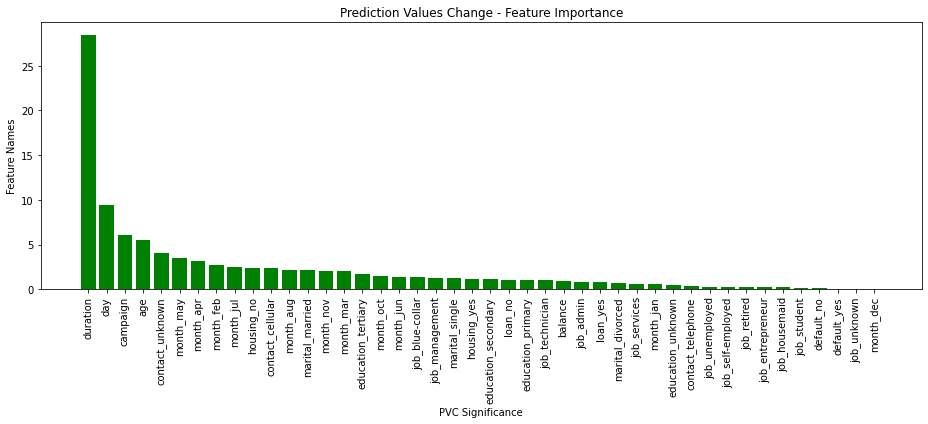

In [30]:
plt.figure(figsize = (13, 6))
plt.bar(PredVals.x, PredVals.y, color = 'green')
plt.xticks(rotation=90)
plt.title("Prediction Values Change - Feature Importance")
plt.xlabel("PVC Significance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

LossFunctionChange involves taking the difference between the metric (Loss function) obtained using the model in 
normal scenario (when we include the feature) and model without each individual feature.

The model is built approximately using the original model with this feature removed from all the trees in the ensemble

Higher the difference, the more important the feature is.

In [35]:
from catboost import Pool
train_x = pd.DataFrame(X_train, columns = data_vals)
train_y = pd.DataFrame(y_train, columns = ["y"])
train_data = Pool(data = train_x,
                  label = train_y)

In [36]:
lfc = list(model.get_feature_importance(train_data, type= "LossFunctionChange"))

In [37]:
data_vals = data.columns[0:44]
LossFn = pd.DataFrame()
LossFn["x"] = data_vals
LossFn["y"] = lfc
LossFn.sort_values("y", inplace = True, ascending = False)

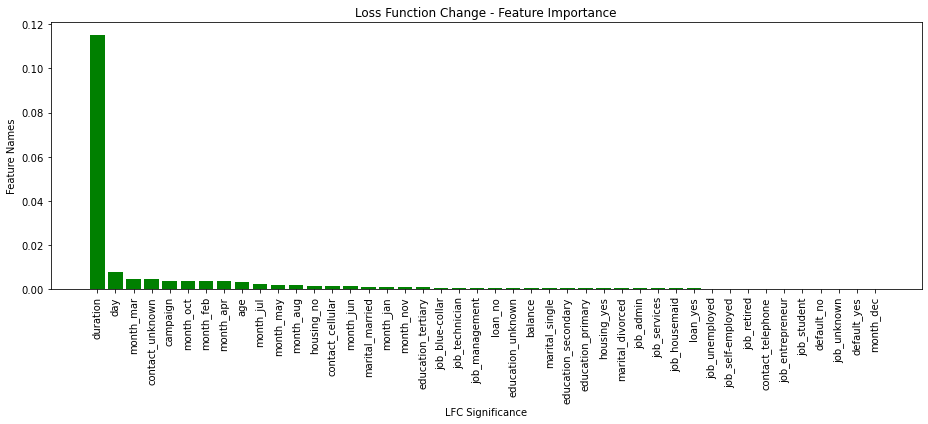

In [39]:
plt.figure(figsize = (13, 6))
plt.bar(LossFn.x, LossFn.y, color = 'green')
plt.xticks(rotation=90)
plt.title("Loss Function Change - Feature Importance")
plt.xlabel("LFC Significance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

SHAP Values (SHapley Additive exPlanations) break down each single prediction to show the impact of each feature on the said prediction

sum(SHAP values for all features) = single_prediction - prediction_for_baseline_values

In [45]:
import shap
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model)

In [58]:
# Calculate Shap values
test_data = pd.DataFrame(X_test, columns = data_vals)
shap_values = explainer.shap_values(test_data)

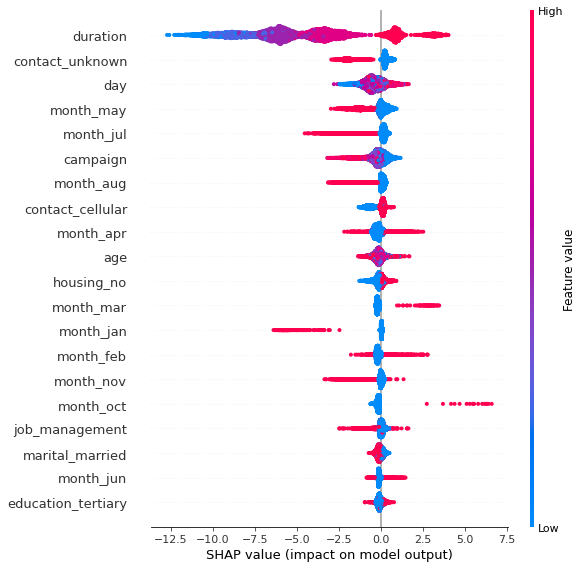

In [59]:
shap.summary_plot(shap_values, test_data)

Permutation Feature Importance
is measured by calculating the increase in model's prediction error after permuting the feature

A feature is "important" if shuffling its values increases the model error
(because in this case the model relied on the feature for the prediction)

A feature is "unimportant" if shuffling its values leaves the model error unchanged
because in this case the model ignored the feature for the prediction)

In [66]:
from sklearn.inspection import permutation_importance
results = permutation_importance(model, X_train, y_train, scoring = f2score)
importance = results.importances_mean

In [69]:
data_vals = data.columns[0:44]
PermImp = pd.DataFrame()
PermImp["x"] = data_vals
PermImp["y"] = list(importance)
PermImp.sort_values("y", inplace = True, ascending = False)

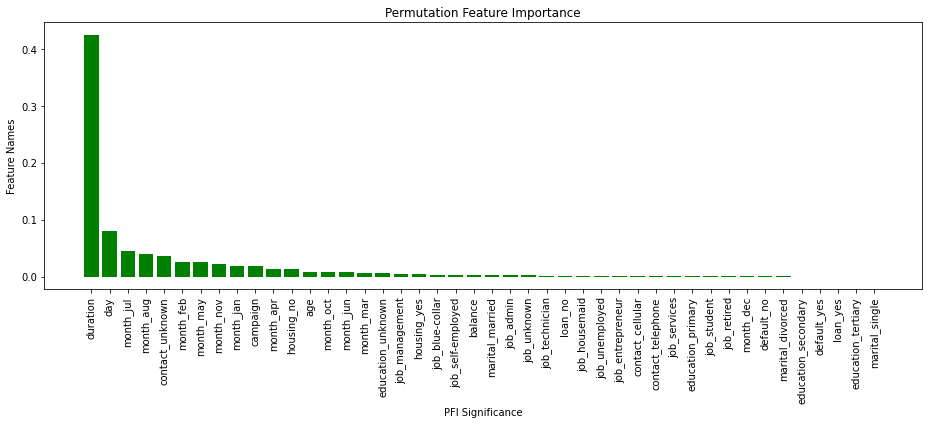

In [70]:
plt.figure(figsize = (13, 6))
plt.bar(PermImp.x, PermImp.y, color = 'green')
plt.xticks(rotation=90)
plt.title("Permutation Feature Importance")
plt.xlabel("PFI Significance")
plt.ylabel("Feature Names")
plt.tight_layout()
plt.show()

Based on the above methods we can conclude that the following features are sigificant to making the prediction:

Duration (last contact duration, in seconds), Day (last contact day of the month), 
A few selective last contact months, campaign (number of contacts performed during this campaign and for a client) and age of the customer


##### Analysing logistic regression coefficient values to determine the expected change in log odds for every unit change in the value of the features

In [239]:
# Using Logistic regression with l2 - ridge penalty
logreg_feat = LogisticRegression(C = 0.2, class_weight = {0: 1, 1: 10}, dual = False, fit_intercept = True,
                                              penalty = 'l2', solver = 'sag', warm_start = True,
                                              random_state = 42, max_iter = 10000)
logreg_feat.fit(X_train,y_train)
coef = logreg_feat.coef_
for i in coef:
    for j in range(0,44):
        print("{:.2f} \t {}".format(i[j] , data.columns[j]))

0.19 	 job_admin
-0.10 	 job_blue-collar
-0.16 	 job_entrepreneur
-0.45 	 job_housemaid
-0.03 	 job_management
0.47 	 job_retired
-0.12 	 job_self-employed
-0.07 	 job_services
0.46 	 job_student
0.11 	 job_technician
-0.09 	 job_unemployed
-0.21 	 job_unknown
0.09 	 marital_divorced
-0.21 	 marital_married
0.11 	 marital_single
-0.07 	 education_primary
0.01 	 education_secondary
0.29 	 education_tertiary
-0.22 	 education_unknown
-0.13 	 default_no
0.13 	 default_yes
0.37 	 housing_no
-0.37 	 housing_yes
0.21 	 loan_no
-0.21 	 loan_yes
0.60 	 contact_cellular
0.55 	 contact_telephone
-1.15 	 contact_unknown
0.27 	 month_apr
-1.74 	 month_aug
0.61 	 month_dec
0.16 	 month_feb
-3.00 	 month_jan
-1.55 	 month_jul
0.40 	 month_jun
2.52 	 month_mar
-0.50 	 month_may
-1.26 	 month_nov
4.09 	 month_oct
-0.39 	 age
1.06 	 balance
0.69 	 day
14.81 	 duration
-0.21 	 campaign


*Based on feature coefficients of logistic regression and feature importances the following can be said about each of the features:*

1) Duration since last contact in a given day:
Duration since last contact seems to have the highest significance with respect to the subscription. 
Larger the duration more likely the customer is to make a subscription.

2) Balance:
Balance has a positive relation with subscription. It makes sense to target consumers that have a high average yearly balance.

3) Age:
In general, a younger demographic is more likely to make the subscription.

4) Day:
People are more likely to subscribe to the deposit when contacted on days later in the month.

5) Campaign:
People that have been contacted a high number of times are less likely to make a subscription.

5) Month:
Contacting people in the following months have had the most success: October, March

Contacting people in the following months have had the least success: January, August, July

6) Education:
People with higher levels of education are more likely to make the financial investment

Job: This is relatively not too significant a feature.

People with the following jobs are more likely to make subscriptions: Retired, Students, Technician, Admin

People with the following jobs are unlikely to make subscriptions: Housemaids, Entrepreneurs, Self-Employed


##### Future Work:

The following methods were implemented but did not yield the desired outcome for the dataset at hand, with a larger dataset in the future they may prove to be beneficial:

Use T-Distributed Stochastic Neighbor Embedding to cluster the data points based on the feature values to determine a stark differentiation between the two class labels.

Using Principal Component Analysis to reduce the dimensionality of the features. With the reduced dimensionality (2/3 dimension) implement K Means clustering to identify clusters of customers and determine segments that should be prioritized to have a better subscription conversion rate.
